In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
Image.LOAD_TRUNCATED_IMAGES = True
from imageio import imread
from datetime import datetime
import shutil
import skimage
import cv2
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

from __future__ import print_function
from keras.models import model_from_json
import keras
from keras import applications
from keras.models import Sequential
from keras.layers import Conv2D,Conv3D,Conv2DTranspose,MaxPooling2D
from keras import backend as K
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.initializers import RandomNormal
from keras.initializers import he_normal
from keras.applications import vgg16 as vgg
from keras.applications.resnet50 import ResNet50
from keras.optimizers import adam
from keras import optimizers
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,concatenate
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import warnings
warnings.filterwarnings("ignore")

In [68]:
pristine_path = "C:/Users/Administrator/Documents/Datasets/Image Forensic Challenge/phase-01-training/dataset-dist/phase-01/training/pristine/pristine_128/"
fake_path  = "C:/Users/Administrator/Documents/Datasets/Image Forensic Challenge/phase-01-training/dataset-dist/phase-01/training/fake/fake_128/"
mask_path = "C:/Users/Administrator/Documents/Datasets/Image Forensic Challenge/phase-01-training/dataset-dist/phase-01/training/maskfiles/mask_128/"

In [69]:
fake_file_names = os.listdir(fake_path)
mask_file_names = os.listdir(mask_path)

In [70]:
len(mask_file_names),len(fake_file_names)

(450, 450)

In [71]:
mask_images=[]
for file in mask_file_names:
    try:
        img=imread(mask_path+file)
    except FileNotFoundError:
        print("No file found")
    
    mask_images.append(img)


# Convert grayscale images to binary
binaries=[]

for grayscale in mask_images:
    blur = cv2.GaussianBlur(grayscale,(5,5),0)
    ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    binaries.append(th)


    
fake_images=[]
for file in fake_file_names:
    try:
        img=imread(fake_path+file)
    except FileNotFoundError:
        print("No file found")
    
    fake_images.append(img)

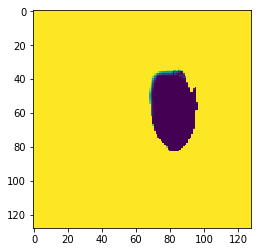

In [72]:
plt.imshow(mask_images[0])

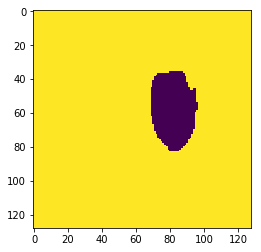

In [73]:
plt.imshow(binaries[0])

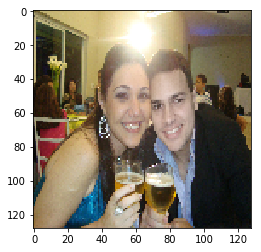

In [74]:
plt.imshow(fake_images[0])

In [75]:
mask_images_arr = np.array(binaries)
fake_images_arr = np.array(fake_images)
type(mask_images_arr),type(fake_images_arr)

(numpy.ndarray, numpy.ndarray)

In [76]:
fake_images_arr.shape,mask_images_arr.shape

((450, 128, 128, 3), (450, 128, 128))

In [77]:
if K.image_data_format() == 'channels_first':
    fake_images_arr = fake_images_arr.reshape(fake_images_arr.shape[0], 3, 128, 128)
    mask_images_arr = mask_images_arr.reshape(mask_images_arr.shape[0], 1, 128, 128)
    input_shape = (1, 128, 128)
else:
    fake_images_arr = fake_images_arr.reshape(fake_images_arr.shape[0], 128, 128, 3)
    mask_images_arr = mask_images_arr.reshape(mask_images_arr.shape[0], 128, 128, 1)
    input_shape = (128, 128, 1)

In [78]:
X = fake_images_arr.astype('float32')
y = mask_images_arr.astype('float32')

# Normalizing the data
X /= 255
y /= 255

print('X shape:', X.shape)
print('y shape:', y.shape)
print(X.shape[0], 'train samples')
print(y.shape[0], 'labels')

X shape: (450, 128, 128, 3)
y shape: (450, 128, 128, 1)
450 train samples
450 labels


In [127]:
y[0][:,:,0]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=42)

In [15]:
# https://stackoverflow.com/questions/51844995/how-do-i-implement-a-loss-function-intersection-over-union-for-a-sequential-mo
def iou(true, pred):

    intersection = true * pred

    notTrue = 1 - true
    union = true + (notTrue * pred)

    return K.sum(intersection)/K.sum(union)

def iou_metric(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

In [16]:
'''
from keras import backend as K
def arr1(shape, dtype=None):
    arr = np.array([[[ 0,  0,  0,  0,  0],
        [ 0,  -1/4,  2/4,  -1/4,  0],
        [ 0,  2/4,  -4/4,  2/4,  0],
        [ 0,  -1/4,  2/4,  -1/4,  0],
        [ 0,  0,  0,  0,  0]],
       [[ -1/12,  2/12,  -2/12,  2/12,  -1/12],
        [ 2/12,  -6/12,  8/12,  -6/12,  2/12],
        [ -2/12,  8/12,  -12/12,  8/12,  -2/12],
        [ 2/12,  -6/12,  8/12,  -6/12,  2/12],
        [ -1/12,  2/12,  -2/12,  2/12,  -1/12]],
       [[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  1/2,  -2/2,  1/2,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]]],np.float32)
    print(shape)
    arr =arr.reshape(shape)
    print(arr.shape)
    return arr

input_img = Input(( 128, 128, 3), name='img')
x = Conv2D(filters = 1, kernel_size = (5,5), kernel_initializer = arr1, padding = 'same')(input_img)
outputs = Conv2D(3, (1,1), activation='sigmoid')(x)
model_noise = Model(inputs=[input_img], outputs=[outputs])
#model_noise.compile(optimizer=optimizers.Adam(), loss="binary_crossentropy", metrics=[iou])

'''

'\nfrom keras import backend as K\ndef arr1(shape, dtype=None):\n    arr = np.array([[[ 0,  0,  0,  0,  0],\n        [ 0,  -1/4,  2/4,  -1/4,  0],\n        [ 0,  2/4,  -4/4,  2/4,  0],\n        [ 0,  -1/4,  2/4,  -1/4,  0],\n        [ 0,  0,  0,  0,  0]],\n       [[ -1/12,  2/12,  -2/12,  2/12,  -1/12],\n        [ 2/12,  -6/12,  8/12,  -6/12,  2/12],\n        [ -2/12,  8/12,  -12/12,  8/12,  -2/12],\n        [ 2/12,  -6/12,  8/12,  -6/12,  2/12],\n        [ -1/12,  2/12,  -2/12,  2/12,  -1/12]],\n       [[ 0,  0,  0,  0,  0],\n        [ 0,  0,  0,  0,  0],\n        [ 0,  1/2,  -2/2,  1/2,  0],\n        [ 0,  0,  0,  0,  0],\n        [ 0,  0,  0,  0,  0]]],np.float32)\n    print(shape)\n    arr =arr.reshape(shape)\n    print(arr.shape)\n    return arr\n\ninput_img = Input(( 128, 128, 3), name=\'img\')\nx = Conv2D(filters = 1, kernel_size = (5,5), kernel_initializer = arr1, padding = \'same\')(input_img)\noutputs = Conv2D(3, (1,1), activation=\'sigmoid\')(x)\nmodel_noise = Model(inputs=[

In [18]:
def srm_filter(shape, dtype=None):
    arr = np.array([[[ 0,  0,  0,  0,  0],
        [ 0,  -1/4,  2/4,  -1/4,  0],
        [ 0,  2/4,  -4/4,  2/4,  0],
        [ 0,  -1/4,  2/4,  -1/4,  0],
        [ 0,  0,  0,  0,  0]],
       [[ -1/12,  2/12,  -2/12,  2/12,  -1/12],
        [ 2/12,  -6/12,  8/12,  -6/12,  2/12],
        [ -2/12,  8/12,  -12/12,  8/12,  -2/12],
        [ 2/12,  -6/12,  8/12,  -6/12,  2/12],
        [ -1/12,  2/12,  -2/12,  2/12,  -1/12]],
       [[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  1/2,  -2/2,  1/2,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]]],np.float32)
    #print(shape)
    arr =arr.reshape(shape)
    #print(arr.shape)
    return arr


def conv2d_block_srm(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""

    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

# the trainable parameter is used by the parent class of all layers (which is called Layer)
# and makes sure that the parameters of that layer are not included in the gradient as trainable parameters.

def get_unet_srm(input_img, n_filters = 16, dropout = 0.1, batchnorm = True,count=0):
    """Function to define the UNET Model"""
    x = Conv2D(filters = 1, kernel_size = (5,5), kernel_initializer = srm_filter, padding = 'same',trainable=False)(input_img)
    # Contracting Path
    c1 = conv2d_block_srm(x, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block_srm(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block_srm(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block_srm(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block_srm(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block_srm(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block_srm(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block_srm(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    #c9 = conv2d_block(u9, 3, kernel_size = 3, batchnorm = batchnorm)
    outputs = conv2d_block_srm(u9, 3, kernel_size = 3, batchnorm = batchnorm)
    model_srm = Model(inputs=[input_img], outputs=[outputs])
    #outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    #model = Model(inputs=[input_img], outputs=[outputs])
    return model_srm

In [19]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    outputs = conv2d_block(u9, 3, kernel_size = 3, batchnorm = batchnorm)
    
    model_reg = Model(inputs=[input_img], outputs=[outputs])
    #outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    #model = Model(inputs=[input_img], outputs=[outputs])
    return model_reg

In [20]:
input_img = Input((128, 128, 3), name='img')

model_reg = get_unet(input_img, n_filters=16, dropout=0.25, batchnorm=False)
model_srm = get_unet_srm(input_img, n_filters=16, dropout=0.25, batchnorm=False)

a = Input(shape=(128, 128, 3))
b = Input(shape=(128, 128, 3))

out_a = model_reg(a)
out_b = model_srm(b)

concatenated = concatenate([out_a, out_b])  # keras.layers.concatenate()
outputs = Conv2D(1, (1, 1), activation='sigmoid')(concatenated)

model = Model([a,b], outputs)

model.compile(optimizer=optimizers.Adam(), loss="binary_crossentropy", metrics=[iou_metric])

In [69]:
#del model


In [70]:

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
model_30 (Model)                (None, 128, 128, 3)  2152695     input_29[0][0]                   
__________________________________________________________________________________________________
model_31 (Model)                (None, 128, 128, 3)  2152483     input_30[0][0]                   
__________________________________________________________________________________________________
concatenat

In [71]:

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-seg_iou_0.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [77]:
results = model.fit([X_train,X_train], y_train, batch_size=64, epochs=20, callbacks=callbacks,\
                    validation_data=([X_test,X_test], y_test))

Train on 351 samples, validate on 99 samples
Epoch 1/20
351/351 [==============================] - 540s 2s/step - loss: 0.5414 - iou_metric: 0.7143 - val_loss: 0.3266 - val_iou_metric: 0.7598

Epoch 00001: val_loss improved from inf to 0.32660, saving model to model-seg_iou_0.h5
Epoch 2/20
351/351 [==============================] - 213s 607ms/step - loss: 0.3297 - iou_metric: 0.8280 - val_loss: 0.2948 - val_iou_metric: 0.7941

Epoch 00002: val_loss improved from 0.32660 to 0.29479, saving model to model-seg_iou_0.h5
Epoch 3/20
351/351 [==============================] - 202s 575ms/step - loss: 0.2983 - iou_metric: 0.8432 - val_loss: 0.2653 - val_iou_metric: 0.8319

Epoch 00003: val_loss improved from 0.29479 to 0.26532, saving model to model-seg_iou_0.h5
Epoch 4/20
351/351 [==============================] - 212s 603ms/step - loss: 0.2861 - iou_metric: 0.8441 - val_loss: 0.2614 - val_iou_metric: 0.8320

Epoch 00004: val_loss improved from 0.26532 to 0.26142, saving model to model-seg_iou

In [79]:
score = model.evaluate([X_test,X_test], y_test, verbose=0)
print('Test loss:', score[0])
print('Test iou:', score[1])

Test loss: 0.2406292450849456
Test iou: 0.8418407711115751


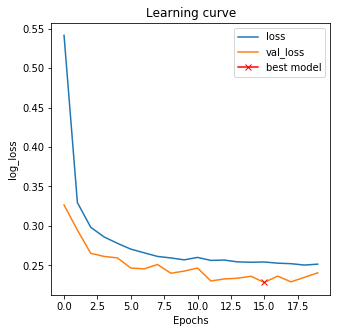

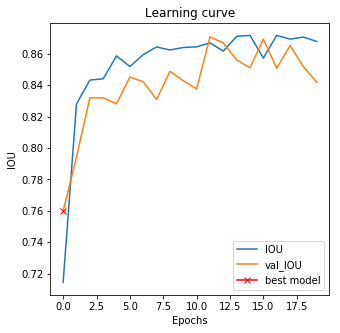

In [80]:
plt.figure(figsize=(5,5))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize=(5,5))
plt.title("Learning curve")
plt.plot(results.history["iou_metric"], label="IOU")
plt.plot(results.history["val_iou_metric"], label="val_IOU")
plt.plot( np.argmin(results.history["val_iou_metric"]), np.min(results.history["val_iou_metric"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("IOU")
plt.legend();

In [89]:

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [80]:
# later...
 
# load json and create model
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")
#print("Loaded model from disk")
 
# evaluate loaded model on test data
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = model.evaluate([X_test,X_test], y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

99/99 [==============================] - 38s 386ms/step
iou_metric: 86.93%


In [81]:
# load the best model
model.load_weights('model-seg_iou_0.h5')
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate([X_test,X_test], y_test, verbose=1)

99/99 [==============================] - 15s 149ms/step


[0.22843704425325298, 0.8693348277698864]

In [82]:
# Predict on train, val and test
preds_train = model.predict([X_train,X_train], verbose=1)
preds_val = model.predict([X_test,X_test], verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

99/99 [==============================] - 17s 172ms/step


In [103]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 3, figsize=(10, 15))
    ax[0].imshow(X[ix])
    ax[0].set_title('original')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('mask')

    ax[2].imshow(preds[ix][:,:,0],cmap='Greys_r')
    ax[2].set_title(' Predicted')
    
   

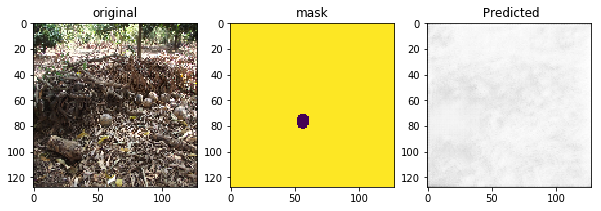

In [104]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=13)

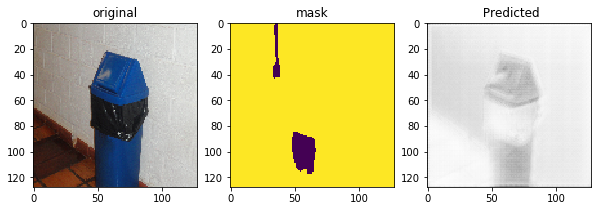

In [87]:
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_val, preds_val_t, ix=13)

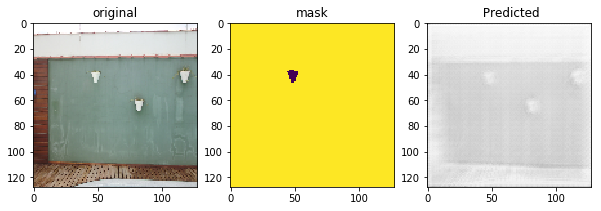

In [105]:
plot_sample(X_test, y_test, preds_val, preds_val_t, ix=55)

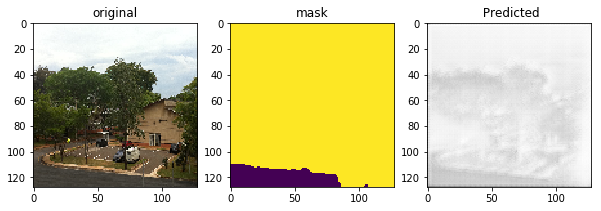

In [112]:
plot_sample(X_test, y_test, preds_val, preds_val_t, ix=16)

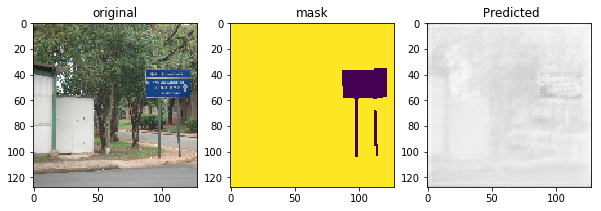

In [90]:
plot_sample(X_test, y_test, preds_val, preds_val_t, ix=72)

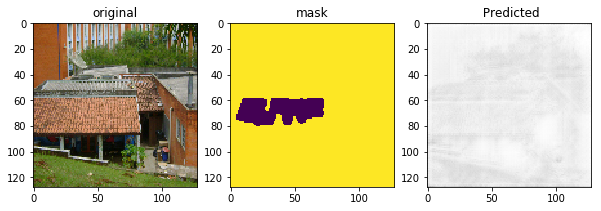

In [111]:
plot_sample(X_test, y_test, preds_val, preds_val_t, ix=57)

In [32]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('original')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('mask')

    ax[2].imshow(preds[ix].squeeze())
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.6])
    ax[2].set_title(' Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze())
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title(' Predicted binary');

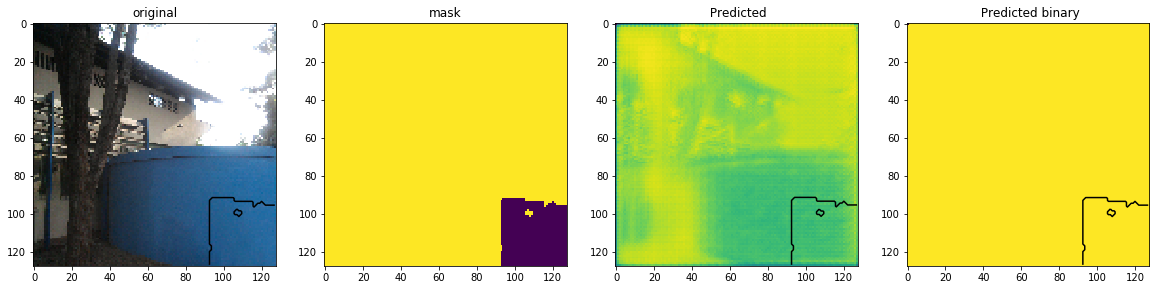

In [104]:
plot_sample(X_test, y_test, preds_val, preds_val_t, ix=32)

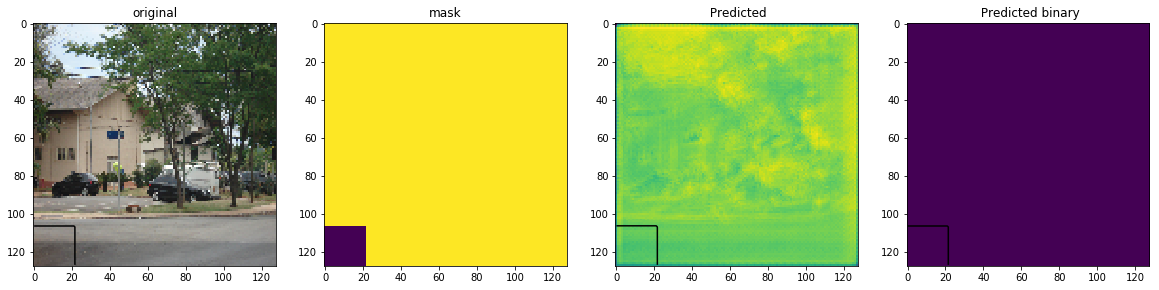

In [107]:
plot_sample(X_test, y_test, preds_val, preds_val_t, ix=0)

In [1]:
############################################################END####################################

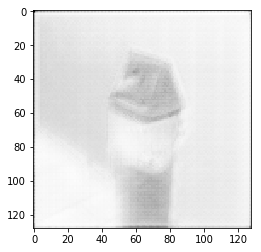

In [108]:
plt.imshow(preds_val[13][:,:,0],cmap='Greys_r')

In [96]:
np.shape(preds_train[13].squeeze())

(128, 128)

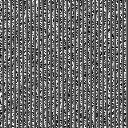

In [110]:
img = Image.fromarray(preds_val[13][:,:,0],mode='L')
img

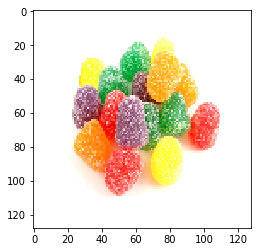

In [28]:
plt.imshow(X[12])

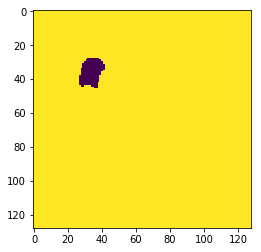

In [31]:
plt.imshow(y[12, ..., 0])

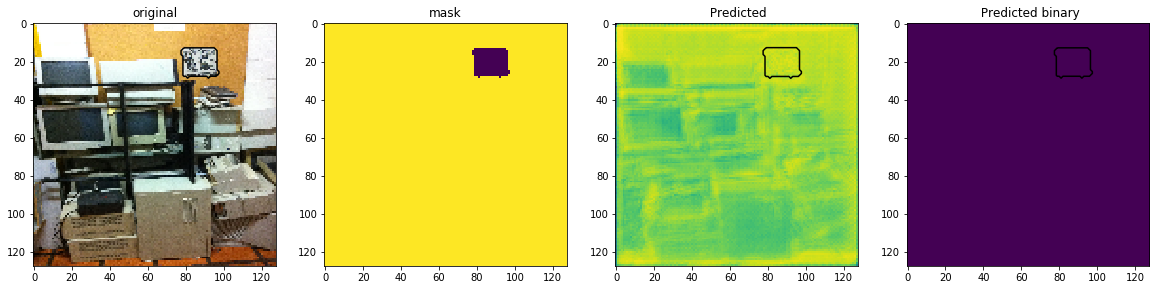

In [34]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=21)

In [ ]:
plot_sample1(X_test, y_test, preds_train, preds_train_t, ix=13)

In [20]:
arr = np.array([[[ 0,  0,  0,  0,  0],
    [ 0,  -1/4,  2/4,  -1/4,  0],
    [ 0,  2/4,  -4/4,  2/4,  0],
    [ 0,  -1/4,  2/4,  -1/4,  0],
    [ 0,  0,  0,  0,  0]],
   [[ -1/12,  2/12,  -2/12,  2/12,  -1/12],
    [ 2/12,  -6/12,  8/12,  -6/12,  2/12],
    [ -2/12,  8/12,  -12/12,  8/12,  -2/12],
    [ 2/12,  -6/12,  8/12,  -6/12,  2/12],
    [ -1/12,  2/12,  -2/12,  2/12,  -1/12]],
   [[ 0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0],
    [ 0,  1/2,  -2/2,  1/2,  0],
    [ 0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0]]],np.float32)

In [21]:
len(arr),len(arr[0])

(3, 5)

In [22]:
arr.shape

(3, 5, 5)

In [23]:
arr = arr.T

In [24]:
arr

array([[[ 0.        , -0.08333334,  0.        ],
        [ 0.        ,  0.16666667,  0.        ],
        [ 0.        , -0.16666667,  0.        ],
        [ 0.        ,  0.16666667,  0.        ],
        [ 0.        , -0.08333334,  0.        ]],

       [[ 0.        ,  0.16666667,  0.        ],
        [-0.25      , -0.5       ,  0.        ],
        [ 0.5       ,  0.6666667 ,  0.5       ],
        [-0.25      , -0.5       ,  0.        ],
        [ 0.        ,  0.16666667,  0.        ]],

       [[ 0.        , -0.16666667,  0.        ],
        [ 0.5       ,  0.6666667 ,  0.        ],
        [-1.        , -1.        , -1.        ],
        [ 0.5       ,  0.6666667 ,  0.        ],
        [ 0.        , -0.16666667,  0.        ]],

       [[ 0.        ,  0.16666667,  0.        ],
        [-0.25      , -0.5       ,  0.        ],
        [ 0.5       ,  0.6666667 ,  0.5       ],
        [-0.25      , -0.5       ,  0.        ],
        [ 0.        ,  0.16666667,  0.        ]],

       [[ 0.

In [34]:
arr.shape

(5, 5, 3)

In [13]:
from keras import backend as K
def arr1(shape, dtype=None):
    arr = np.array([[[ 0,  0,  0,  0,  0],
        [ 0,  -1/4,  2/4,  -1/4,  0],
        [ 0,  2/4,  -4/4,  2/4,  0],
        [ 0,  -1/4,  2/4,  -1/4,  0],
        [ 0,  0,  0,  0,  0]],
       [[ -1/12,  2/12,  -2/12,  2/12,  -1/12],
        [ 2/12,  -6/12,  8/12,  -6/12,  2/12],
        [ -2/12,  8/12,  -12/12,  8/12,  -2/12],
        [ 2/12,  -6/12,  8/12,  -6/12,  2/12],
        [ -1/12,  2/12,  -2/12,  2/12,  -1/12]],
       [[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  1/2,  -2/2,  1/2,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]]],np.float32)
    print(shape)
    arr =arr.reshape(shape)
    print(arr.shape)
    return arr

input_img = Input(( 128, 128, 3), name='img')
x = Conv2D(filters = 1, kernel_size = (5,5), kernel_initializer = arr1, padding = 'same')(input_img)
outputs = Conv2D(3, (1,1), activation='sigmoid')(x)
model_noise = Model(inputs=[input_img], outputs=[outputs])
#model_noise.compile(optimizer=optimizers.Adam(), loss="binary_crossentropy", metrics=[iou])

(5, 5, 3, 1)
(5, 5, 3, 1)


In [14]:
img = np.expand_dims(X[0], axis=0)
maps = model_noise.predict(img)
print("*"*5)
print(np.shape(maps))

*****
(1, 128, 128, 3)


In [98]:
del model_noise

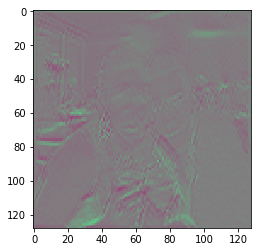

In [15]:
plt.imshow(maps.squeeze())

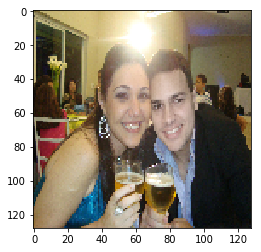

In [142]:
plt.imshow(X[0].squeeze())

In [147]:
from keras import backend as K
def arr1(shape, dtype=None):
    arr = np.array([[[ 0,  0,  0,  0,  0],
        [ 0,  -1/4,  2/4,  -1/4,  0],
        [ 0,  2/4,  -4/4,  2/4,  0],
        [ 0,  -1/4,  2/4,  -1/4,  0],
        [ 0,  0,  0,  0,  0]],
       [[ -1/12,  2/12,  -2/12,  2/12,  -1/12],
        [ 2/12,  -6/12,  8/12,  -6/12,  2/12],
        [ -2/12,  8/12,  -12/12,  8/12,  -2/12],
        [ 2/12,  -6/12,  8/12,  -6/12,  2/12],
        [ -1/12,  2/12,  -2/12,  2/12,  -1/12]],
       [[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  1/2,  -2/2,  1/2,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]]],np.float32)
    #print(shape)
    arr =arr.reshape(shape)
    #print(arr.shape)
    return arr

input_img = Input(( 128, 128, 3), name='img')
x = Conv2D(filters = 1, kernel_size = (5,5), kernel_initializer = arr1, padding = 'same')(input_img)
x = Conv2D(filters = 3, kernel_size = (5,5), kernel_initializer = arr1, padding = 'same')(x)
x = Conv2D(filters = 1, kernel_size = (5,5), kernel_initializer = arr1, padding = 'same')(x)
x = Conv2D(filters = 3, kernel_size = (5,5), kernel_initializer = arr1, padding = 'same')(x)
x = Conv2D(filters = 1, kernel_size = (5,5), kernel_initializer = arr1, padding = 'same')(x)
x = Conv2D(filters = 3, kernel_size = (5,5), kernel_initializer = arr1, padding = 'same')(x)
#x = Conv2D(filters = 1, kernel_size = (5,5), kernel_initializer = arr1, padding = 'same')(x)
outputs = Conv2D(3, (1,1), activation='sigmoid')(x)
model_noise = Model(inputs=[input_img], outputs=[outputs])
#model_noise.compile(optimizer=optimizers.Adam(), loss="binary_crossentropy", metrics=[iou])

img = np.expand_dims(X[0], axis=0)
maps = model_noise.predict(img)
print("*"*5)
print(np.shape(maps))

*****
(1, 128, 128, 3)


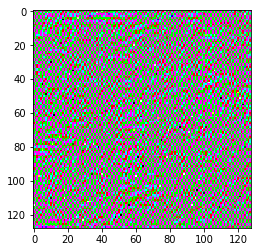

In [148]:
plt.imshow(maps.squeeze())

In [146]:
del model_noise

In [37]:
from keras import backend as K
def arr1(shape, dtype=None):
    arr = np.array([[[ 0,  0,  0,  0,  0],
        [ 0,  -1/4,  2/4,  -1/4,  0],
        [ 0,  2/4,  -4/4,  2/4,  0],
        [ 0,  -1/4,  2/4,  -1/4,  0],
        [ 0,  0,  0,  0,  0]],
       [[ -1/12,  2/12,  -2/12,  2/12,  -1/12],
        [ 2/12,  -6/12,  8/12,  -6/12,  2/12],
        [ -2/12,  8/12,  -12/12,  8/12,  -2/12],
        [ 2/12,  -6/12,  8/12,  -6/12,  2/12],
        [ -1/12,  2/12,  -2/12,  2/12,  -1/12]],
       [[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  1/2,  -2/2,  1/2,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]]],np.float32)
    #print(shape)
    arr =arr.reshape(shape)
    #print(arr.shape)
    return arr

input_img = Input(( 128, 128, 3), name='img')
x = Conv2D(filters = 1, kernel_size = (5,5), kernel_initializer = arr1, padding = 'same')(input_img)
#x = Activation('relu')(x)
#x = Conv2D(filters = 3, kernel_size = (5,5), kernel_initializer = arr1, padding = 'same')(x)
#x = Conv2D(filters = 16, kernel_size = (3,3), padding = 'same')(x)
#x = Activation('relu')(x)
#x = Conv2D(filters = 3, kernel_size = (5,5), padding = 'same')(x)
#x = Conv2D(filters = 1, kernel_size = (5,5), padding = 'same')(x)
#x = Conv2D(filters = 3, kernel_size = (5,5), padding = 'same')(x)
#x = Conv2D(filters = 1, kernel_size = (5,5), kernel_initializer = arr1, padding = 'same')(x)
outputs = Conv2D(3, (1,1), activation='sigmoid')(x)
model_noise = Model(inputs=[input_img], outputs=[outputs])
#model_noise.compile(optimizer=optimizers.Adam(), loss="binary_crossentropy", metrics=[iou])

img = np.expand_dims(X[10], axis=0)
maps = model_noise.predict(img)
print("*"*5)
print(np.shape(maps))

*****
(1, 128, 128, 3)


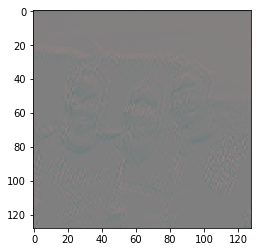

In [38]:
plt.imshow(maps.squeeze())

In [21]:
x

<tf.Tensor 'conv2d_15/BiasAdd:0' shape=(?, 128, 128, 3) dtype=float32>

In [93]:
from keras import backend as K
def arr1(shape, dtype=None):
    arr = np.array([[[ 0,  0,  0,  0,  0],
        [ 0,  -1/4,  2/4,  -1/4,  0],
        [ 0,  2/4,  -4/4,  2/4,  0],
        [ 0,  -1/4,  2/4,  -1/4,  0],
        [ 0,  0,  0,  0,  0]],
       [[ -1/12,  2/12,  -2/12,  2/12,  -1/12],
        [ 2/12,  -6/12,  8/12,  -6/12,  2/12],
        [ -2/12,  8/12,  -12/12,  8/12,  -2/12],
        [ 2/12,  -6/12,  8/12,  -6/12,  2/12],
        [ -1/12,  2/12,  -2/12,  2/12,  -1/12]],
       [[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  1/2,  -2/2,  1/2,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]]],np.float32)
    print(shape)
    arr =arr.reshape(shape)
    print(arr.shape)
    return arr

input_img = Input(( 128, 128, 3), name='img')
x = Conv2D(filters = 3, kernel_size = (5,5), kernel_initializer = arr1, padding = 'same')(input_img)

(5, 5, 3, 3)


ValueError: cannot reshape array of size 75 into shape (5,5,3,3)

In [88]:
input_img = Input(( 128, 128, 3), name='img')

In [89]:
x = Conv2D(filters = 1, kernel_size = (5,5),\
              kernel_initializer = arr1, padding = 'same')(input_img)

(5, 5, 3, 1)
[[[[ 0.        ]
   [ 0.        ]
   [ 0.        ]]

  [[ 0.        ]
   [ 0.        ]
   [ 0.        ]]

  [[-0.25      ]
   [ 0.5       ]
   [-0.25      ]]

  [[ 0.        ]
   [ 0.        ]
   [ 0.5       ]]

  [[-1.        ]
   [ 0.5       ]
   [ 0.        ]]]


 [[[ 0.        ]
   [-0.25      ]
   [ 0.5       ]]

  [[-0.25      ]
   [ 0.        ]
   [ 0.        ]]

  [[ 0.        ]
   [ 0.        ]
   [ 0.        ]]

  [[ 0.        ]
   [-0.08333334]
   [ 0.16666667]]

  [[-0.16666667]
   [ 0.16666667]
   [-0.08333334]]]


 [[[ 0.16666667]
   [-0.5       ]
   [ 0.6666667 ]]

  [[-0.5       ]
   [ 0.16666667]
   [-0.16666667]]

  [[ 0.6666667 ]
   [-1.        ]
   [ 0.6666667 ]]

  [[-0.16666667]
   [ 0.16666667]
   [-0.5       ]]

  [[ 0.6666667 ]
   [-0.5       ]
   [ 0.16666667]]]


 [[[-0.08333334]
   [ 0.16666667]
   [-0.16666667]]

  [[ 0.16666667]
   [-0.08333334]
   [ 0.        ]]

  [[ 0.        ]
   [ 0.        ]
   [ 0.        ]]

  [[ 0.        ]
   [ 0.   

In [75]:
x.shape

TensorShape([Dimension(None), Dimension(128), Dimension(128), Dimension(1)])

In [101]:
from keras import backend as K

def my_init(shape, dtype=None):
    #print(type(K.random_normal(shape, dtype=dtype)))
    weights = K.random_normal(shape, dtype=dtype)
    print(type(weights),weights.shape)
    print(weights)
    return weights


x = Conv2D(filters = 3, kernel_size = (5,5),\
              kernel_initializer = my_init, padding = 'same')(input_img)
x = Conv2D(filters = 1, kernel_size = (5,5), padding = 'same')(x)
x = Conv2D(filters = 1, kernel_size = (5,5), padding = 'same')(x)

<class 'tensorflow.python.framework.ops.Tensor'> (5, 5, 3, 3)
Tensor("conv2d_45/random_normal:0", shape=(5, 5, 3, 3), dtype=float32)


In [97]:
x

<tf.Tensor 'conv2d_35/BiasAdd:0' shape=(?, 128, 128, 1) dtype=float32>

In [16]:
fake_images_arr

array([[[[122, 111,  57],
         [ 99,  88,  42],
         [122, 102,  49],
         ...,
         [127, 118,  87],
         [130, 114,  89],
         [125, 111,  85]],

        [[135, 130,  88],
         [133, 113,  80],
         [134, 119,  80],
         ...,
         [125, 110,  87],
         [124, 112,  86],
         [123, 108,  79]],

        [[167, 153, 114],
         [146, 143,  90],
         [141, 129,  91],
         ...,
         [123, 108,  85],
         [109,  99,  72],
         [114, 105,  74]],

        ...,

        [[146, 110,  50],
         [153, 120,  69],
         [160, 122,  77],
         ...,
         [ 20,  17,  12],
         [ 21,  19,  22],
         [ 14,  13,  11]],

        [[150, 114,  62],
         [157, 115,  65],
         [145, 111,  74],
         ...,
         [ 20,  21,  16],
         [ 15,  19,  18],
         [ 17,  27,  28]],

        [[158, 116,  66],
         [149, 117,  78],
         [156, 119,  77],
         ...,
         [ 19,  24,  20],
        